## <center style="color:red;">**Brain & Blood Analyzer**</center>

### **Diagnostic multimodal par IA : Cancers sanguins & Tumeurs cérébrales via Transfer Learning**

Ce projet combine la détection de tumeurs cérébrales (YOLOv8) et la classification de cellules sanguines cancéreuses (PyTorch) dans une solution unifiée d’analyse d’images médicales par deep learning, visant un diagnostic assisté précis et automatisé.

### <span style="color:green;">**Préparation des données YOLO :**</span>

#### <span style="color:blue;">**1. Importer les librairies nécessaires :**</span>

In [1]:
import torch as tr
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile as zpf
import cv2

#### <span style="color:blue;">**2. Chargement des Images :**</span>

##### **2.1. Définir les chemins pour le fichier ZIP et le dossier de décompression :**

In [2]:
zip_path = "../src/infrastructure/data/Brain/zip/Data_Brain.zip"
extract_path = "../src/infrastructure/data/Brain/extracted"

##### **2.2. Décompresser le ZIP :**

In [3]:
if os.path.exists(zip_path) :
    print(f"Décompression de {zip_path} vers {extract_path} :")
    with zpf.ZipFile(zip_path, 'r') as z :
        if os.path.exists(extract_path) :
            z.extractall(extract_path)
        else :
            print(f"{extract_path} Non Trouvé !")
    print("Décompression Terminée.")
else :
    print(f"{zip_path} Non Trouvé !")

Décompression de ../src/infrastructure/data/Brain/zip/Data_Brain.zip vers ../src/infrastructure/data/Brain/extracted :
Décompression Terminée.


##### **2.3. Trouver toutes les classes :**

In [4]:
classes = []

for dir in os.listdir(extract_path) :
    dir_path = os.path.join(extract_path, dir)

    if os.path.isdir(dir_path):
        for classe in os.listdir(dir_path):
            classe_dir = os.path.join(dir_path, classe)

            if os.path.isdir(classe_dir) and (classe not in classes):
                classes.append(classe)

print(classes)

['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']


#### <span style="color:blue;">**3. Préparation des images et labels au format YOLO :**</span>

##### **3.1. Afficher un échantillon d’images pour chaque classe avec les boîtes englobantes :**

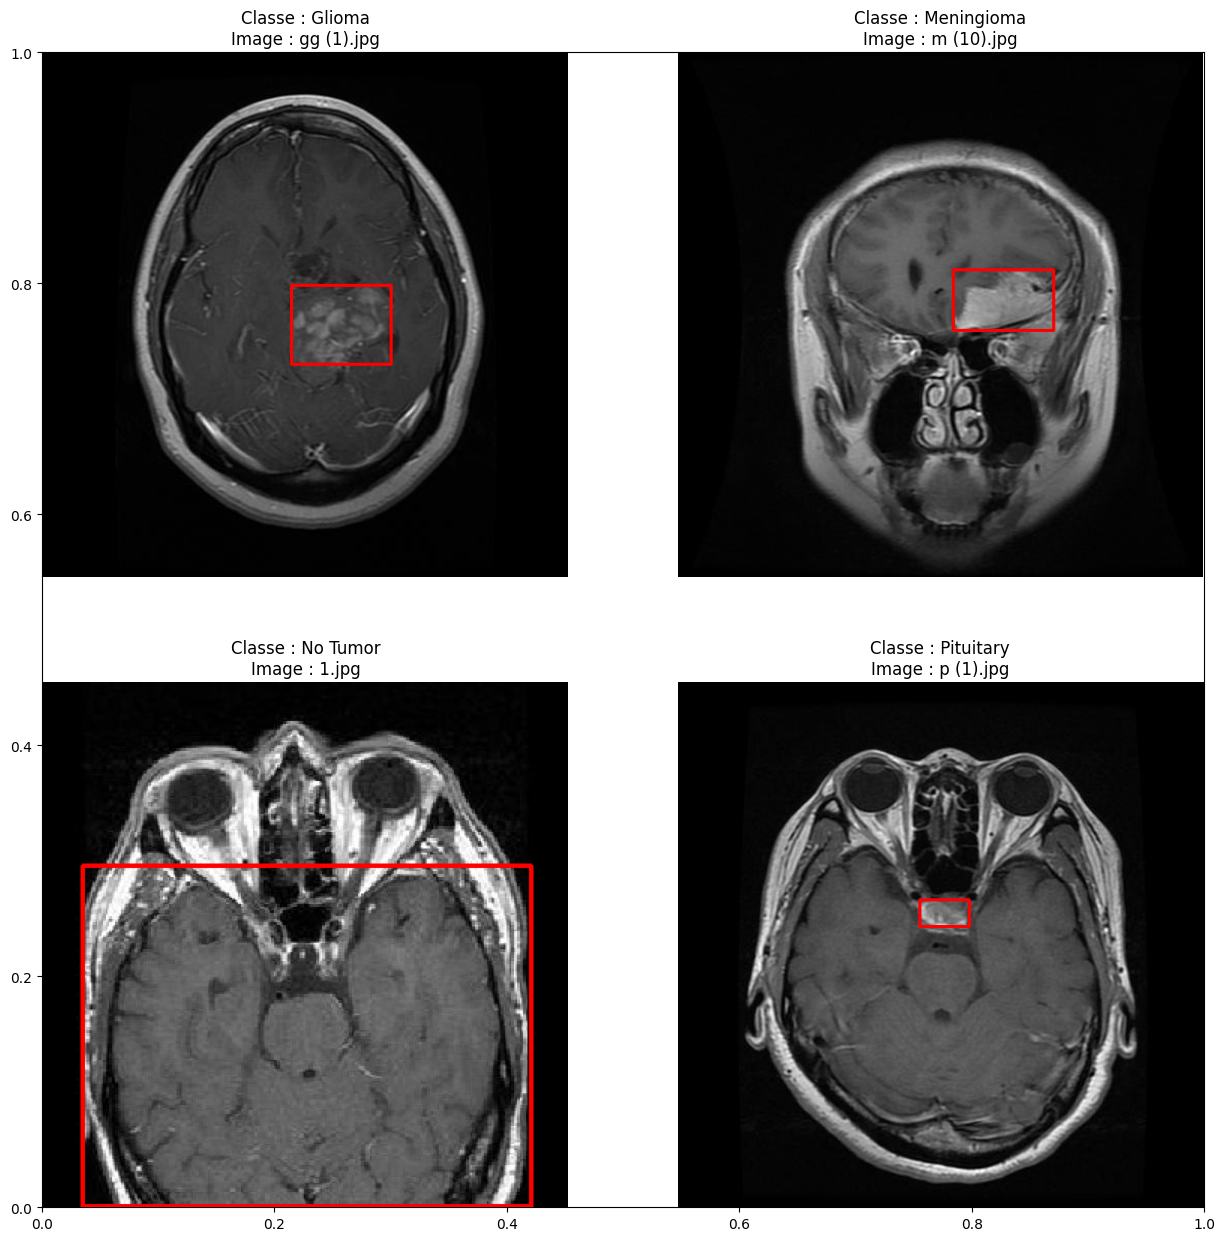

In [5]:
# Définir le chemin du dossier d'entraînement
data_path = '../src/infrastructure/data/Brain/extracted/Train'

plt.subplots(figsize=(15,15))

for i, classe in enumerate(classes) :

    # Définir les chemins vers les images et les labels de cette classe
    images_path = os.path.join(data_path, classe, 'images') # Ex: '../src/infrastructure/data/Brain/extracted/Train/Glioma/images'
    labels_path = os.path.join(data_path, classe, 'labels') # Ex: '../src/infrastructure/data/Brain/extracted/Train/Glioma/labels'

    # Prendre la première image du dossier
    image = os.listdir(images_path)[0]

    # Construire le chemin complet vers le fichier label correspondant (.txt)
    image_label = os.path.join(labels_path, image.split('.')[0] + '.txt')

    if os.path.exists(image_label):
        # Lire l’image + Convertir BGR à RGB
        img = cv2.imread(images_path + '/' + image)
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Récupérer les dimensions de l’image
        height, width, channels = img.shape

        with open(image_label, "r") as file :
            for line in file.readlines() :

                # Chaque ligne correspond à une boîte : [class_id, x_center, y_center, width, height]
                coordinates = line.strip().split()
                cls_id, x_center, y_center, box_w, box_h = map(float, coordinates)

                # Convertir les coordonnées normalisées (YOLO) en pixels réels
                x_center *= width
                y_center *= height
                box_w *= width
                box_h *= height

                # Calculer les coordonnées du coin supérieur gauche (x1, y1) et du coin inférieur droit (x2, y2)
                x1 = int(x_center - box_w / 2)
                y1 = int(y_center - box_h / 2)
                x2 = int(x_center + box_w / 2)
                y2 = int(y_center + box_h / 2)

                # Dessiner la boîte englobante sur l’image
                cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
    
    
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(f"Classe : {classe}\nImage : {image}")
    plt.axis("off")

plt.show()

                

##### **3.2. Créer un dossier pour stocker les données après filtrage :**

In [6]:
new_dir_path = "../src/infrastructure/data/Brain/dataset"

os.mkdir(new_dir_path)

print("Dossier crée avec Succés !")

Dossier crée avec Succés !


##### **3.3. Vérifier pour chaque image a un fichier ``.txt`` correspondant :**

In [7]:
import shutil

# Définir le chemin du dossier contenant les données d’origine
old_data_path = "../src/infrastructure/data/Brain/extracted"

# Définir le chemin du nouveau dossier où seront stockées les données filtrées
new_data_path = "../src/infrastructure/data/Brain/dataset"

for folder in os.listdir(old_data_path) :
    # Construire le chemin complet vers le dossier actuel (ex: ../Brain/extracted/Train)
    folder_path = os.path.join(old_data_path, folder)

    # Construire le chemin du nouveau dossier où les données filtrées seront copiées
    new_folder_path = os.path.join(new_data_path, folder)

    # Créer les sous-dossiers 'images' et 'labels' dans le nouveau dossier
    try :
        os.makedirs(os.path.join(new_folder_path, 'images'))
        os.makedirs(os.path.join(new_folder_path, 'labels'))
    except :
        pass

    for classe in classes :
        # Construire le chemin du dossier de la classe actuelle
        classe_folder_path = os.path.join(folder_path, classe)

        # Récupérer les chemins vers les sous-dossiers d’images et de labels
        images_folder = os.path.join(classe_folder_path, 'images')
        labels_folder = os.path.join(classe_folder_path, 'labels')

        for image in os.listdir(images_folder) :
            # Extraire le nom du fichier sans extension (ex: 'image' depuis 'image.jpg')
            image_name = image.split('.')[0]

            # Vérifier si un fichier label (.txt) correspondant à cette image existe
            if os.path.exists(f"{labels_folder}/{image_name}.txt") :
                # Chemin source de l’image et du label
                image_source = os.path.join(images_folder, image)
                image_dest = os.path.join(new_folder_path, 'images', image)

                # Chemin de destination dans le nouveau dossier
                label_source = os.path.join(labels_folder, image_name + ".txt")
                label_dest = os.path.join(new_folder_path, 'labels', image_name + ".txt")

                # Copier les fichiers image et label dans le nouveau répertoire
                shutil.copy(image_source, image_dest)
                shutil.copy(label_source, label_dest)
                
            # Si le fichier label n’existe pas, afficher un message d’avertissement
            else :
                print(f"{image_name} n'a pas de Label !")

image(55) n'a pas de Label !
image(61) n'a pas de Label !


#### <span style="color:blue;">**4. Création des fichiers ``.yaml`` nécessaires à YOLOv8 :**</span>

##### **4.1. Créer le fichier ``data.yaml`` :**

In [9]:
import yaml

data_config = {
    "train": "../src/infrastructure/data/Brain/dataset/Train",  
    "val": "../src/infrastructure/data/Brain/dataset/Val",
    "nc": len(classes),   
    "names": classes,     
    "augment": False      
}

with open("../data.yaml", "w") as file:
    yaml.dump(data_config, file, sort_keys=False)

print(f"Fichier data.yaml créé avec Succès !")

Fichier data.yaml créé avec Succès !


##### **4.2. Créer le fichier ``data2.yaml`` avec augmentation :**

In [10]:
import yaml

data_config = {
    "train": "../src/infrastructure/data/Brain/dataset/Train",  
    "val": "../src/infrastructure/data/Brain/dataset/Val",
    "nc": len(classes),   
    "names": classes,     
    "augment": True      
}

with open("../data2.yaml", "w") as file:
    yaml.dump(data_config, file, sort_keys=False)

print(f"Fichier data2.yaml créé avec Succès !")

Fichier data2.yaml créé avec Succès !


#### <span style="color:blue;">**5. Vérification des Images avec leurs Labels :**</span>

##### **5.1. Compter le nombre d’images et d’étiquettes :**

In [11]:
data_path = "../src/infrastructure/data/Brain/dataset"

counts = {}

for folder in os.listdir(data_path) :
    images_path = os.path.join(data_path, folder, "images")
    labels_path = os.path.join(data_path, folder, "labels")

    count_images = len(os.listdir(images_path))
    count_labels = len(os.listdir(labels_path))

    print(f"- Le nombre des Images de {folder} est : {count_images} Images.")
    print(f"- Le nombre des Labels de {folder} est : {count_labels} Labels.")

    count = {
        "images" : count_images,
        "labels" : count_labels
    }

    counts.setdefault(f"{folder}", count)

- Le nombre des Images de Train est : 4737 Images.
- Le nombre des Labels de Train est : 4737 Labels.
- Le nombre des Images de Val est : 510 Images.
- Le nombre des Labels de Val est : 510 Labels.


In [12]:
total_images = counts["Train"]["images"] + counts["Val"]["images"]

print(f"- Pourcentage des Images en Train : {counts["Train"]["images"] * 100 / total_images :.2f}%")
print(f"- Pourcentage des Images en Validation : {(counts["Val"]["images"] *100 / total_images) :.2f}%")

- Pourcentage des Images en Train : 90.28%
- Pourcentage des Images en Validation : 9.72%
